In [2]:
import csv
from shared.plot import get_dict_data
import pylab as pl
from IPython import display
import torch
from torch.distributions import Categorical
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path

from shared.plot import plot_geodesic, plot_hierarchy
from shared.io import read_data, read_ref
from shared.math import eval_reconstruction
from riemannian_sgd import RiemannianSGD
from model import Model


OUT_DIMENSIONS = 3
NEG_SAMPLES = 50
EPOCH = 300
torch.set_default_dtype(torch.float64)

loading now
loading done
Loaded configuration file /Users/henrikjohn/Library/Jupyter/runtime/kernel-61c9bd5c-a395-4ebf-8e24-ecad963c238a.json
{'shell_port': 63164, 'iopub_port': 63165, 'stdin_port': 63166, 'control_port': 63168, 'hb_port': 63167, 'ip': '127.0.0.1', 'key': 'dfddffc5-0b5540114ea940f534d7618f', 'transport': 'tcp', 'signature_scheme': 'hmac-sha256', 'kernel_name': ''}


/Users/henrikjohn/Git/omop-poincare/configs/config.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


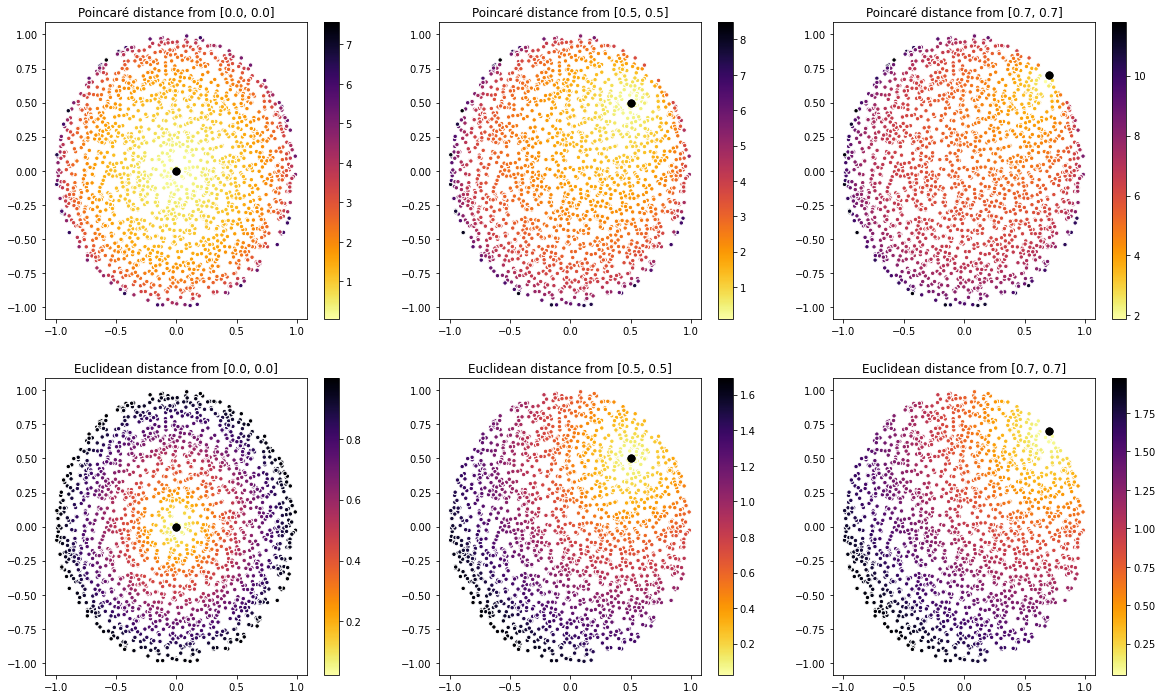

In [2]:
# Plot geodesic comparison between Poincaré and Euclidean
plot_geodesic()

In [3]:
# Load edge data
data_path = Path("data","dist1Sample.csv")
data, weights, objects, neighbors, diff_summed, num_relations = read_data(data_path)

# load concept reference
ref_path = Path('data','ref.csv')
ref = read_ref(ref_path)


Processing dataset...
Dataset size: 246
Relations: 246
Vocabulary size: 229


dictData[1]: 441840
Graph with 229 nodes and 246 edges


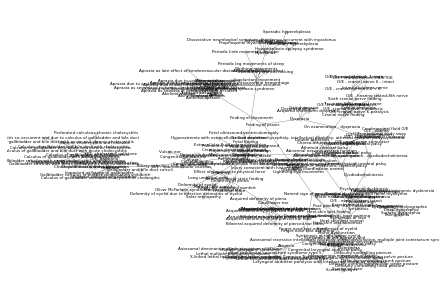

In [3]:
# plot only small hierarchies
if len(data) < 10000:
    plot_hierarchy(data, objects, ref)

In [ ]:
cat_dist = Categorical(probs=torch.from_numpy(weights)) # was weights
unif_dist = Categorical(probs=torch.ones(len(objects),) / len(objects))

model = Model(dim=OUT_DIMENSIONS, size=len(objects))
optimizer = RiemannianSGD(model.parameters())

loss_func = CrossEntropyLoss()
batch_X = torch.zeros(10, NEG_SAMPLES + 2, dtype=torch.long)
batch_y = torch.zeros(10, dtype=torch.long)

EPOCH = 200
n = 0

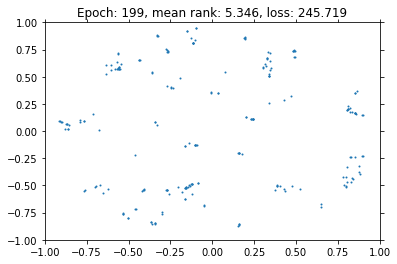

100%|██████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 358.00it/s]


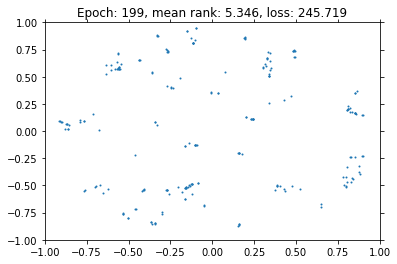

In [5]:
pl.figure()
# pl.xlim(-1, 1)
# pl.ylim(-1, 1)
# pl.axis('off')
epoch_loss = 0.0
mean_rank = 0.0
while n < EPOCH:
    print(f"Epoch: {n}")
    if n < 40:
        lr = 0.003
        sampler = cat_dist
    else:
        lr = 0.3
        sampler = unif_dist

    perm = torch.randperm(data.shape[0])
    # dataset_rnd = data.loc[perm, ]
    dataset_rnd = torch.as_tensor(data[perm, ])

##############################################
    coordinates = model.embedding.weight.detach().numpy()
    # pl.annotate(dictData[x], (coordinates[x,0], coordinates[x,1]), fontsize=4)
    pl.gca().clear()
    pl.xlim(-1, 1)
    pl.ylim(-1, 1)
    pl.title(f"Epoch: {n}, mean rank: {round(mean_rank, 3)}, loss: {round(epoch_loss, 3)}")
    pl.scatter(coordinates[:,0], coordinates[:,1],s=1)
    display.clear_output(wait=True)
    display.display(pl.gcf())
##############################################

    for i in tqdm(range(0, data.shape[0] - data.shape[0] % 10, 10)):
    # for i in range(0, data.shape[0] - data.shape[0] % 10, 10):
        batch_X[:, :2] = dataset_rnd[i: i + 10]

        for j in range(10):
            negatives = sampler.sample([2 * NEG_SAMPLES]).unique(sorted=False)
            negatives = negatives[(negatives != batch_X[j, 0]) & (negatives != batch_X[j, 1])]
            batch_X[j, 2 : negatives.size(0)+2] = negatives[:NEG_SAMPLES]

            ## Alternative implementation of constructing batch
            # a = set(sampler.sample([2 * NEG_SAMPLES]).numpy())
            # negatives = list(a - (set(data[batch_X[j, 0]]) | set(data[batch_X[j, 1]])))
            # batch_X[j, 2 : len(negatives)+2] = torch.LongTensor(negatives[:NEG_SAMPLES])

        optimizer.zero_grad()
        preds = model(batch_X)

        loss = loss_func(preds.neg(), batch_y)
        loss.backward()
        optimizer.step(lr=lr)

        # rank and loss output
        epoch_loss += loss.item()
    if n % 10 == 0:
        with torch.no_grad():
            mean_rank = eval_reconstruction(model, num_relations, neighbors, diff_summed)
        epoch_loss /= data.shape[0] // 10
        print(f"Mean rank: {mean_rank}, loss: {epoch_loss}")
    n = n+1
# reset counter to allow continuation of training
n = 0

dictData[1]: 441840
0                                    Finding of movement
1                                       Clinical finding
2                       Inconsistent carbohydrate intake
3                            Recent Zika virus infection
4                                          Wound finding
                             ...                        
224    Severe microbrachycephaly, intellectual disabi...
225                       Chorea-athetoid cerebral palsy
226                                     Double athetosis
227                        Dystonic/rigid cerebral palsy
228    Acute and chronic cholecystitis co-occurrent a...
Length: 229, dtype: object
Processing dataset...
Dataset size: 246
Relations: 246
Vocabulary size: 229


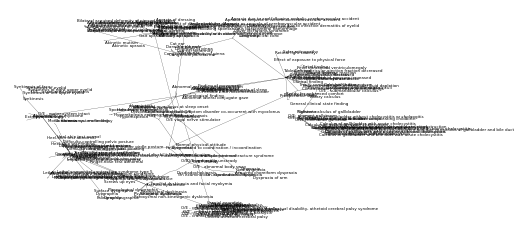

In [11]:
dict_data = get_dict_data(objects, ref)
# model = torch.load("poincare_model_dim_2.pt")
# coordinates = model["state_dict"]["embedding.weight"].numpy()
# print(model.state_dict()['embedding.weight'])
coordinates = model.embedding.weight
# print(coordinates)
#######################################################
# some experiment with 3d plotting in TF projector
x_np = coordinates.detach().numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv(Path('output','tf_proj_vec.tsv'), sep="\t", index=False, header=False)

df = pd.Series(dict_data)
df.to_string()
print(df)
df.to_csv(Path('output','tf_proj_lab.tsv'), sep="\t", index=False, header=False,
          quoting=csv.QUOTE_NONNUMERIC)
# df["index"].map(dictData)
###########################

# print(len(objects))
#print(data)

plt.figure()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')

data, weights, objects, neighbors, diff_summed, num_relations = read_data("data/dist1Sample.csv")

# add some jitter to better see labels
jitter = 0.05
jitter_x = np.random.uniform(low=-jitter, high = jitter, size=(coordinates.shape[0], ))
jitter_y = np.random.uniform(low=-jitter, high = jitter, size=(coordinates.shape[0], ))

for x in range(coordinates.shape[0]):
    plt.annotate(dict_data[x], (coordinates[x,0].detach().numpy()+jitter_x[x],
                               coordinates[x,1].detach().numpy()+jitter_y[x]), fontsize=4)
    # plt.annotate(dictData[x], (coordinates[x,0]*100, coordinates[x,1]*100),
    #              bbox={"fc":"white", "alpha":0.9}, fontsize=4)

# Plot edges of original hierarchy
for i in range(data.shape[0]):
    x_values = [coordinates[data[i][0], 0].detach().numpy(), coordinates[data[i][1], 0].detach().numpy()]
    y_values = [coordinates[data[i][0], 1].detach().numpy(), coordinates[data[i][1], 1].detach().numpy()]
#
#     x_val = [coordinates[data[x][0],0].detach().numpy(), coordinates[data[x][1],1].detach().numpy()]
#     y_val = [coordinates[data[x][0],0].detach().numpy(), coordinates[data[x][1],1].detach().numpy()]
    plt.plot(x_values, y_values, color="black", linewidth=0.2)

plt.savefig(Path("output", "hierarchy_embed.png"), dpi=300, facecolor="white")
plt.show()